In [ ]:
#Import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import tensorflow as tf

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LakshmanReddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LakshmanReddy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LakshmanReddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LakshmanReddy\AppData\Roaming\nltk_data...


Libraries imported.


[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#Load and inspect dataset
df = pd.read_csv('data/tripadvisor_hotel_reviews.csv')

In [ ]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
print(f"Dataset shape: {df.shape}")


Dataset shape: (20491, 2)


In [6]:
print(f"Columns: {df.columns.tolist()}")

Columns: ['Review', 'Rating']


In [ ]:
# Clean up any NaN 
df = df.dropna().reset_index(drop=True)

In [8]:
# Convert Rating to integer
df['Rating'] = df['Rating'].astype(str).str.extract('(\d+)').astype(int)
df['Review'] = df['Review'].astype(str)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\LakshmanReddy\AppData\Local\Temp\ipykernel_12848\1436774502.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['Rating'] = df['Rating'].astype(str).str.extract('(\d+)').astype(int)


In [ ]:
df.dtypes

Review    object
Rating     int32
dtype: object

In [10]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# EDA 


C:\Users\LakshmanReddy\AppData\Local\Temp\ipykernel_12848\1346282352.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis')


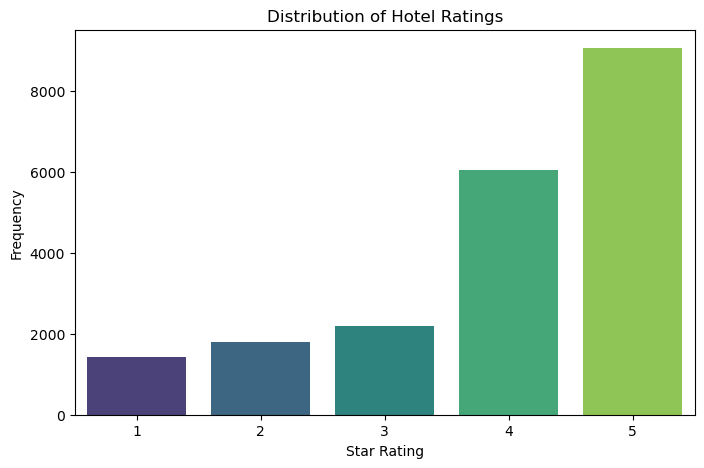

In [11]:
# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribution of Hotel Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.show()


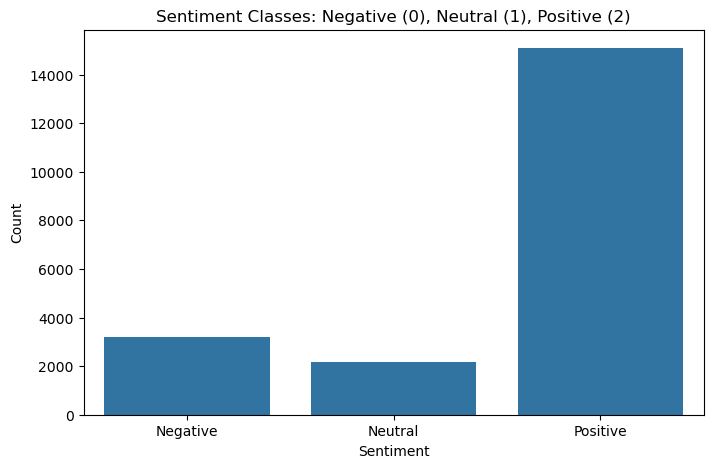

In [12]:

# Map to sentiment: Negative (1-2), Neutral (3), Positive (4-5)
df['Sentiment'] = df['Rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

# Plot sentiment classes
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Classes: Negative (0), Neutral (1), Positive (2)')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Count')
plt.show()

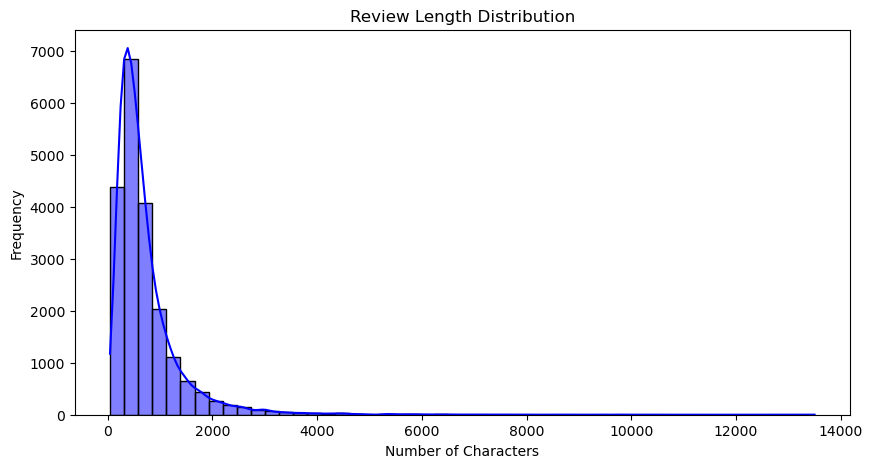

In [ ]:
# Review length
df['Length'] = df['Review'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df['Length'], bins=50, kde=True, color='blue')
plt.title('Review Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


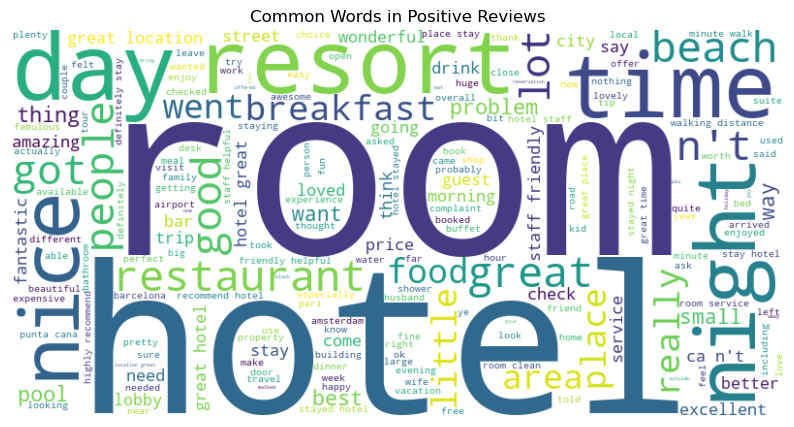

In [15]:
# Word Cloud for positive reviews
positive_reviews = ' '.join(df[df['Sentiment'] == 2]['Review'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Positive Reviews')
plt.show()

## Text Cleaning

In [ ]:
#Define text cleaning function
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply cleaning
df['Cleaned_Review'] = df['Review'].apply(clean_text)
print("Sample cleaned review:")
print(df['Cleaned_Review'].iloc[0])

Sample cleaned review:
nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night


## Word frequency analysis


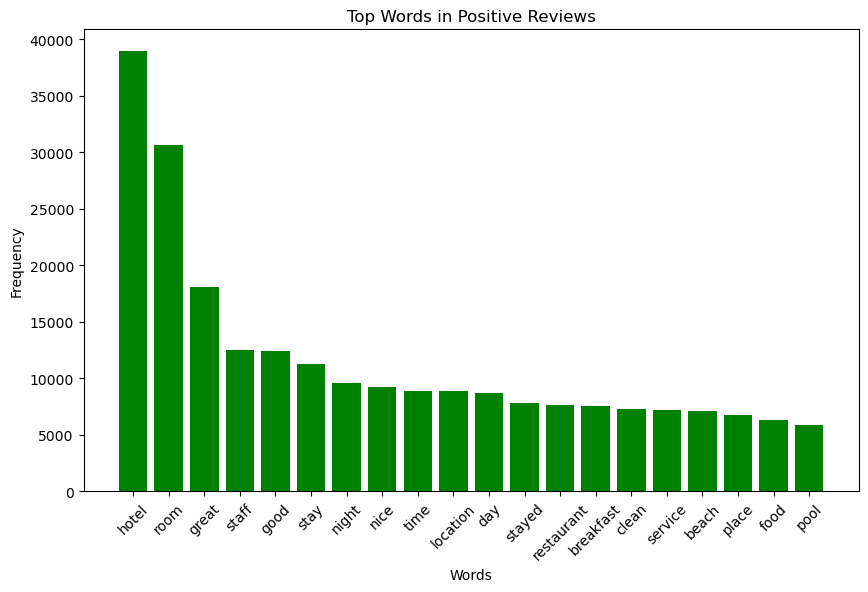

In [ ]:
# Word frequency analysis
from collections import Counter

# Top words in positive reviews
top_words = Counter(" ".join(df[df['Sentiment'] == 2]['Cleaned_Review']).split()).most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='green')
plt.title('Top Words in Positive Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [18]:
#load GloVe embeddings
def load_glove_embeddings(filepath, dim=100):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            if len(vector) == dim:
                embeddings[word] = vector
    print(f"Loaded {len(embeddings)} word vectors.")
    return embeddings

# Update path if needed
embeddings_index = load_glove_embeddings('glove.6B.100d.txt', 100)

Loaded 400000 word vectors.


Tokenization & Padding

In [19]:
# Tokenization and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 5000
MAX_LEN = 150

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Cleaned_Review'])

X = tokenizer.texts_to_sequences(df['Cleaned_Review'])
X = pad_sequences(X, maxlen=MAX_LEN)

y = pd.get_dummies(df['Sentiment']).values  # One-hot encode

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (20491, 150)
y shape: (20491, 3)


In [20]:
#Create embedding matrix
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_WORDS:
        continue
    vec = embeddings_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (5000, 100)


In [22]:
#Save tokenizer and embedding matrix
import pickle
import os

# Create folders
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Save tokenizer
with open('data/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save embedding matrix
np.save('data/embedding_matrix.npy', embedding_matrix)

print("Tokenizer and embedding matrix saved.")

Tokenizer and embedding matrix saved.


In [24]:
#Define Attention Layer
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer='he_normal',
            trainable=True,
            name='attention_W'
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='attention_b'
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer='he_normal',
            trainable=True,
            name='attention_u'
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = tf.einsum("btf,f->bt", u_it, self.u)
        a_it = K.softmax(a_it, axis=1)
        weighted = x * K.expand_dims(a_it, -1)
        return K.sum(weighted, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [26]:
#Build all models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2

#Dense Model
def build_dense():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=MAX_LEN, trainable=False),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN Model
def build_cnn():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=MAX_LEN, trainable=False),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# LSTM Model
def build_lstm():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=MAX_LEN, trainable=False),
        LSTM(64, dropout=0.5, recurrent_dropout=0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# BiLSTM + Attention
def build_bilstm_attention():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=MAX_LEN, trainable=False),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
        AttentionLayer(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
#Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df['Sentiment'], random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16392, 150)
X_test shape: (4099, 150)
y_train shape: (16392, 3)
y_test shape: (4099, 3)


In [28]:
df.head()

,Review,Rating,Sentiment,Length,Cleaned_Review
0,nice hotel expensive parking got good deal sta...,4,2,593,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,0,1689,nothing special charge diamond member hilton d...
2,nice rooms not 4* experience hotel monaco seat...,3,1,1427,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,2,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,2,1281,great stay great stay went seahawk game awesom...


In [ ]:
#Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
]

## Training 

C:\Users\LakshmanReddy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Dense...
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.6078 - loss: 0.9372 - val_accuracy: 0.7365 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7443 - loss: 0.6921 - val_accuracy: 0.7734 - val_loss: 0.6002 - learning_rate: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7667 - loss: 0.6197 - val_accuracy: 0.7960 - val_loss: 0.5458 - learning_rate: 0.0010
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7945 - loss: 0.5750 - val_accuracy: 0.8114 - val_loss: 0.5206 - learning_rate: 0.0010
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8039 - loss: 0.5520 - val_accuracy: 0.8146 - val_loss: 0.5045 - learning_rate: 0.0010
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8053 - loss: 0.5409 - val_accuracy: 0.8153 - val_loss: 0.5025 - learning_rate: 0.0010
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accurac

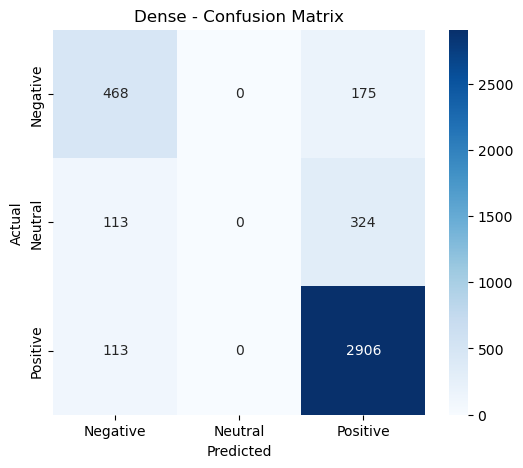


Dense Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.73      0.70       643
     Neutral       0.00      0.00      0.00       437
    Positive       0.85      0.96      0.90      3019

    accuracy                           0.82      4099
   macro avg       0.51      0.56      0.53      4099
weighted avg       0.73      0.82      0.78      4099


Training CNN...
Epoch 1/20


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.6961 - loss: 1.2948 - val_accuracy: 0.8029 - val_loss: 0.7150 - learning_rate: 0.0010
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.7936 - loss: 0.6863 - val_accuracy: 0.8046 - val_loss: 0.5892 - learning_rate: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8348 - loss: 0.5088 - val_accuracy: 0.8348 - val_loss: 0.4792 - learning_rate: 0.0010
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.8495 - loss: 0.4414 - val_accuracy: 0.8341 - val_loss: 0.5201 - learning_rate: 0.0010
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.8635 - loss: 0.3819 - val_accuracy: 0.8441 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8774 - loss: 0.3391 - val_accuracy: 0.8275 - val_loss: 0.4597 - learning_rate: 0.0010
Epoch 7/20
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8888 - loss: 0.2905
Ep

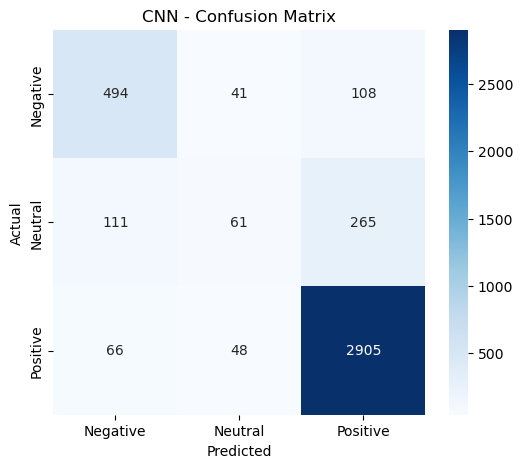


CNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.77      0.75       643
     Neutral       0.41      0.14      0.21       437
    Positive       0.89      0.96      0.92      3019

    accuracy                           0.84      4099
   macro avg       0.68      0.62      0.63      4099
weighted avg       0.81      0.84      0.82      4099


Training LSTM...
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.7235 - loss: 0.8088 - val_accuracy: 0.7365 - val_loss: 0.7183 - learning_rate: 0.0010
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 302ms/step - accuracy: 0.7347 - loss: 0.7407 - val_accuracy: 0.7592 - val_loss: 0.6052 - learning_rate: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 34s 266ms/step - accuracy: 0.7417 - loss: 0.6942 - val_accuracy: 0.7831 - val_loss: 0.5956 - learning_rate: 0.0010
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 304ms/step - accuracy: 0.7534 - loss: 0.6462 - val_accuracy: 0.8

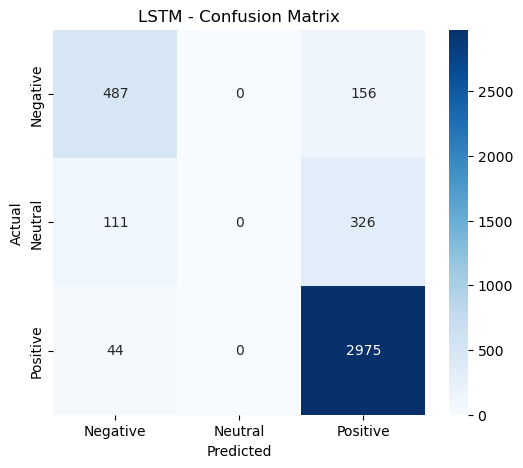


LSTM Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76       643
     Neutral       0.00      0.00      0.00       437
    Positive       0.86      0.99      0.92      3019

    accuracy                           0.84      4099
   macro avg       0.54      0.58      0.56      4099
weighted avg       0.75      0.84      0.80      4099



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Train Dense, CNN, LSTM
models = {
    "Dense": build_dense(),
    "CNN": build_cnn(),
    "LSTM": build_lstm(),
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    # Evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = y_test.argmax(axis=1)

    results[name] = {
        'model': model,
        'history': history,
        'accuracy': acc,
        'y_true': y_true_classes,
        'y_pred': y_pred_classes
    }

    # Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Classification Report
    from sklearn.metrics import classification_report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes,
                                target_names=['Negative', 'Neutral', 'Positive']))

In [44]:
#Train BiLSTM + Attention
print("\nTraining BiLSTM + Attention...")
model_bilstm = build_bilstm_attention()
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Evaluate
loss, acc = model_bilstm.evaluate(X_test, y_test, verbose=0)
y_pred = model_bilstm.predict(X_test, verbose=0)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

results["BiLSTM_Attention"] = {
    'model': model_bilstm,
    'history': history_bilstm,
    'accuracy': acc,
    'y_true': y_true_classes,
    'y_pred': y_pred_classes
}



Training BiLSTM + Attention...


C:\Users\LakshmanReddy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7041 - loss: 0.8180 - val_accuracy: 0.7756 - val_loss: 0.6376 - learning_rate: 0.0010
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 99s 763ms/step - accuracy: 0.7845 - loss: 0.5887 - val_accuracy: 0.8180 - val_loss: 0.4717 - learning_rate: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 97s 752ms/step - accuracy: 0.8152 - loss: 0.5217 - val_accuracy: 0.8348 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 96s 742ms/step - accuracy: 0.8243 - loss: 0.4893 - val_accuracy: 0.8404 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 97s 750ms/step - accuracy: 0.8265 - loss: 0.4775 - val_accuracy: 0.8412 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 100s 776ms/step - accuracy: 0.8324 - loss: 0.4641 - val_accuracy: 0.8424 - val_loss: 0.4056 - learning_rate: 0.0010
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 102s 789ms/step - accuracy: 0.8

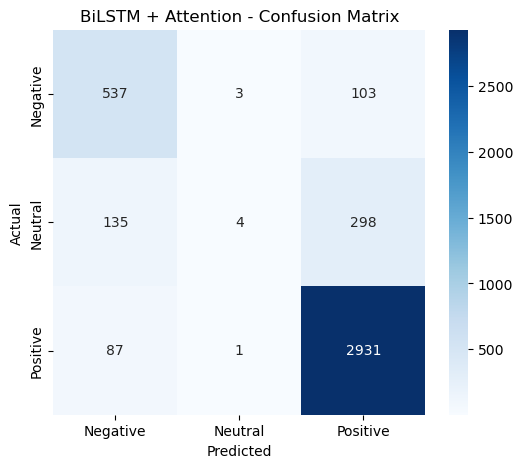


BiLSTM + Attention Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.84      0.77       643
     Neutral       0.50      0.01      0.02       437
    Positive       0.88      0.97      0.92      3019

    accuracy                           0.85      4099
   macro avg       0.70      0.61      0.57      4099
weighted avg       0.81      0.85      0.80      4099



In [48]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('BiLSTM + Attention - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("\nBiLSTM + Attention Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=['Negative', 'Neutral', 'Positive']))

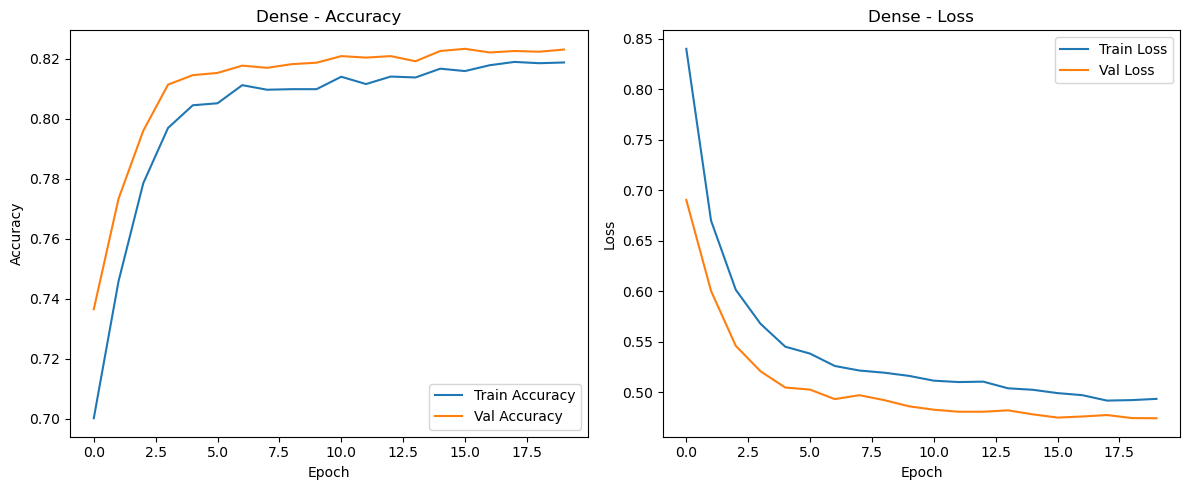

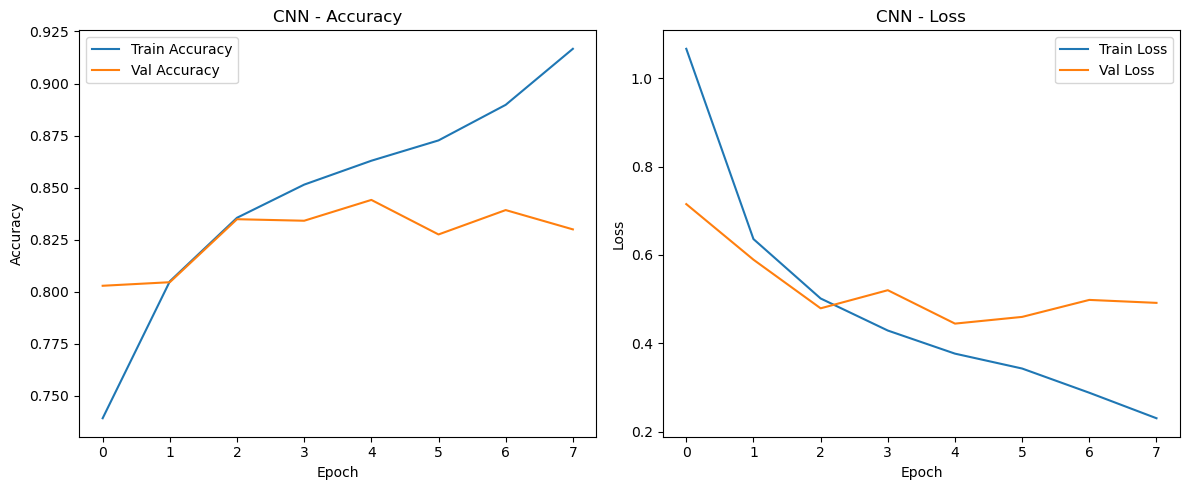

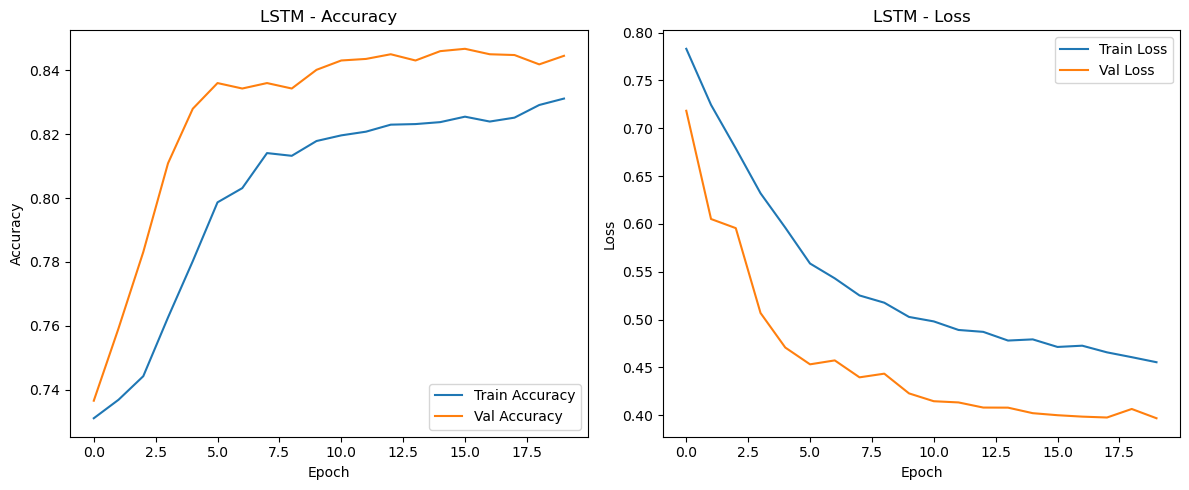

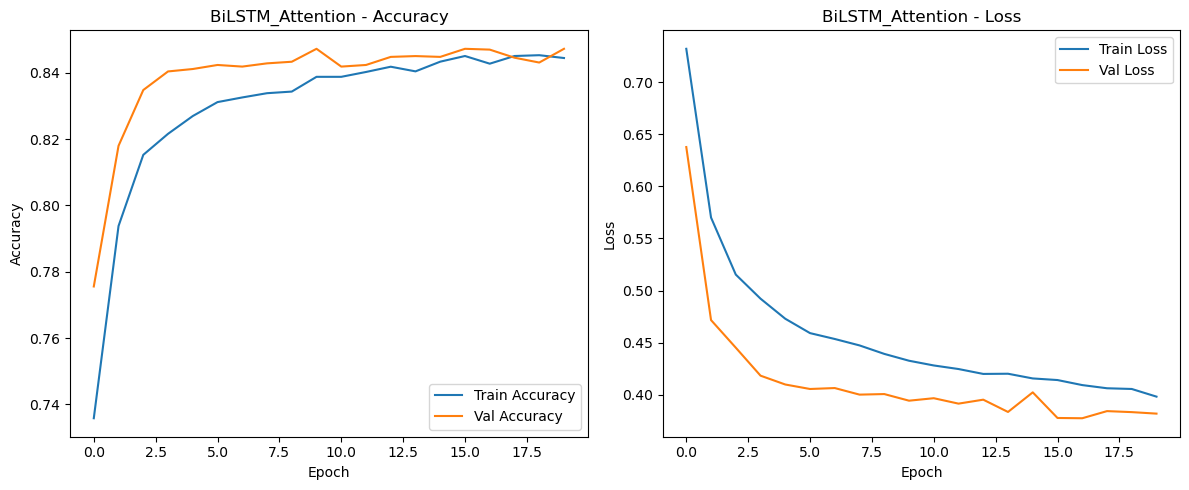

In [50]:
#Plot training history
def plot_history(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for each model
for name, res in results.items():
    plot_history(res['history'], title=name)

In [49]:
# Cell 19: Save all models
for name, result in results.items():
    result['model'].save(f'models_without_ClassWeights/{name}_model.h5')

print("All models saved.")

All models saved.


In [47]:
#Error analysis
import numpy as np

for model_name, result in results.items():
    y_true = result['y_true']
    y_pred = result['y_pred']
    wrong_idx = np.where(y_true != y_pred)[0]

    print(f"\n--- {model_name} - Misclassified Examples ---")
    for i in range(min(5, len(wrong_idx))):
        idx = wrong_idx[i]
        actual = ['Negative', 'Neutral', 'Positive'][y_true[idx]]
        pred = ['Negative', 'Neutral', 'Positive'][y_pred[idx]]
        print(f"Actual: {actual} | Predicted: {pred}")
        print(f"Review: {df['Review'].iloc[idx]}")
        print("-" * 60)


--- Dense - Misclassified Examples ---
Actual: Neutral | Predicted: Negative
Review: ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away

In [53]:
def predict_sentiment(review_text, model, tokenizer, max_len=150):
    cleaned = clean_text(review_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded, verbose=0)[0]
    labels = ['Negative', 'Neutral', 'Positive']
    pred_class = labels[pred.argmax()]
    confidence = pred.max()
    return pred_class, confidence

# Test
review = "The hotel was great, but the AC didn’t work."
# Run prediction on all models
for name, result in results.items():
    label, conf = predict_sentiment(review, result['model'], tokenizer)
    print(f"{name}: {label} (Confidence: {conf:.2f})")


Dense: Positive (Confidence: 0.88)
CNN: Positive (Confidence: 0.96)
LSTM: Positive (Confidence: 0.93)
BiLSTM_Attention: Positive (Confidence: 0.84)


## Using class weights, Re training the models



In [65]:

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on y_train only
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train.argmax(axis=1)),
    y=y_train.argmax(axis=1)  
)

# Convert to dictionary format Keras expects
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)



Class Weights: {0: 2.1252430960715674, 1: 3.1276473955352033, 2: 0.4525426536359119}


C:\Users\LakshmanReddy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Dense...
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3411 - loss: 1.0902 - val_accuracy: 0.7634 - val_loss: 0.9613 - learning_rate: 0.0010
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6520 - loss: 1.0045 - val_accuracy: 0.7165 - val_loss: 0.8672 - learning_rate: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6979 - loss: 0.9050 - val_accuracy: 0.7160 - val_loss: 0.8028 - learning_rate: 0.0010
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6989 - loss: 0.8691 - val_accuracy: 0.7041 - val_loss: 0.7805 - learning_rate: 0.0010
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6814 - loss: 0.8461 - val_accuracy: 0.7487 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7093 - loss: 0.8198 - val_accuracy: 0.7136 - val_loss: 0.7261 - learning_rate: 0.0010
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6

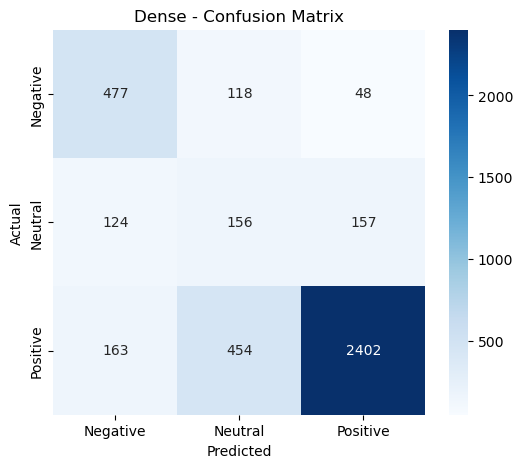


Dense Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.74      0.68       643
     Neutral       0.21      0.36      0.27       437
    Positive       0.92      0.80      0.85      3019

    accuracy                           0.74      4099
   macro avg       0.59      0.63      0.60      4099
weighted avg       0.80      0.74      0.76      4099


Training CNN...
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.3938 - loss: 1.5972 - val_accuracy: 0.6953 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6158 - loss: 1.0666 - val_accuracy: 0.7207 - val_loss: 0.7669 - learning_rate: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.7154 - loss: 0.8405 - val_accuracy: 0.7255 - val_loss: 0.7223 - learning_rate: 0.0010
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.7509 - loss: 0.7370 - val_accuracy: 0.7319

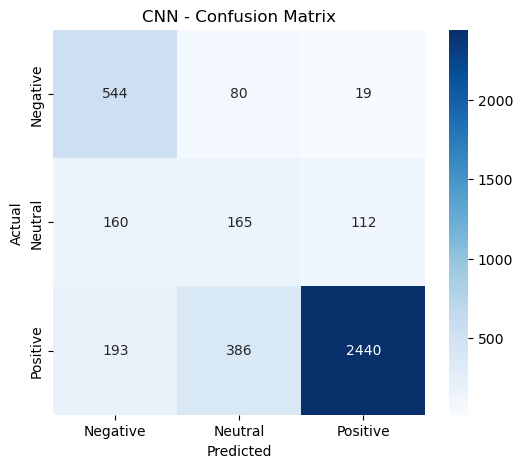


CNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.61      0.85      0.71       643
     Neutral       0.26      0.38      0.31       437
    Positive       0.95      0.81      0.87      3019

    accuracy                           0.77      4099
   macro avg       0.61      0.68      0.63      4099
weighted avg       0.82      0.77      0.79      4099


Training LSTM...
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.3911 - loss: 1.1169 - val_accuracy: 0.4669 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 49s 376ms/step - accuracy: 0.4034 - loss: 1.0797 - val_accuracy: 0.4862 - val_loss: 1.0552 - learning_rate: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 50s 390ms/step - accuracy: 0.5066 - loss: 1.0607 - val_accuracy: 0.6887 - val_loss: 0.8522 - learning_rate: 0.0010
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step - accuracy: 0.5667 - loss: 0.9940 - val_accuracy: 0.7

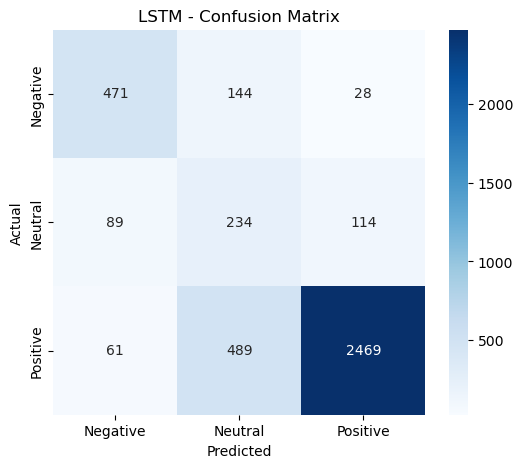


LSTM Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.73      0.75       643
     Neutral       0.27      0.54      0.36       437
    Positive       0.95      0.82      0.88      3019

    accuracy                           0.77      4099
   macro avg       0.66      0.70      0.66      4099
weighted avg       0.84      0.77      0.80      4099



In [ ]:
# retrain Dense, CNN, LSTM with Class weights
models = {
    "Dense": build_dense(),
    "CNN": build_cnn(),
    "LSTM": build_lstm(),
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        class_weight=class_weights_dict, # now using class weights for this iteration
        verbose=1
    )
    # Evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = y_test.argmax(axis=1)

    results[name] = {
        'model': model,
        'history': history,
        'accuracy': acc,
        'y_true': y_true_classes,
        'y_pred': y_pred_classes
    }

    # Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Classification Report
    from sklearn.metrics import classification_report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes,
                                target_names=['Negative', 'Neutral', 'Positive']))

In [34]:
#Train BiLSTM + Attention
print("\nTraining BiLSTM + Attention...")
model_bilstm = build_bilstm_attention()
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

# Evaluate
loss, acc = model_bilstm.evaluate(X_test, y_test, verbose=0)
y_pred = model_bilstm.predict(X_test, verbose=0)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

results["BiLSTM_Attention"] = {
    'model': model_bilstm,
    'history': history_bilstm,
    'accuracy': acc,
    'y_true': y_true_classes,
    'y_pred': y_pred_classes
}



Training BiLSTM + Attention...
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.3847 - loss: 1.0891 - val_accuracy: 0.7495 - val_loss: 0.7315 - learning_rate: 0.0010
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6337 - loss: 0.9211 - val_accuracy: 0.7899 - val_loss: 0.5849 - learning_rate: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.6987 - loss: 0.8328 - val_accuracy: 0.7575 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6993 - loss: 0.7881
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
129/129 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.6994 - loss: 0.7880 - val_accuracy: 0.7556 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.7247 - loss: 0.7564 - val_accuracy: 0.7690 - val_loss: 0.5579 - learning_rate: 5.0000e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/s

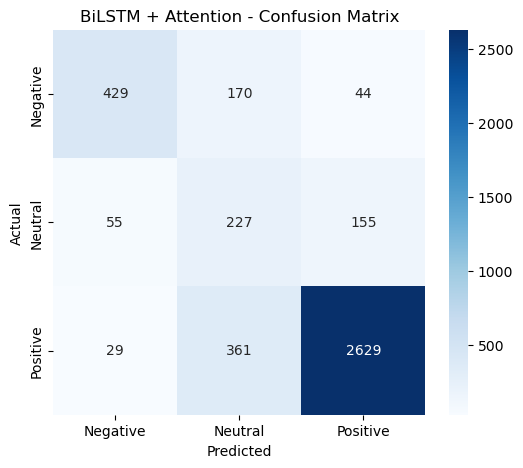


BiLSTM + Attention Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.67      0.74       643
     Neutral       0.30      0.52      0.38       437
    Positive       0.93      0.87      0.90      3019

    accuracy                           0.80      4099
   macro avg       0.69      0.69      0.67      4099
weighted avg       0.85      0.80      0.82      4099



In [35]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('BiLSTM + Attention - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("\nBiLSTM + Attention Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=['Negative', 'Neutral', 'Positive']))

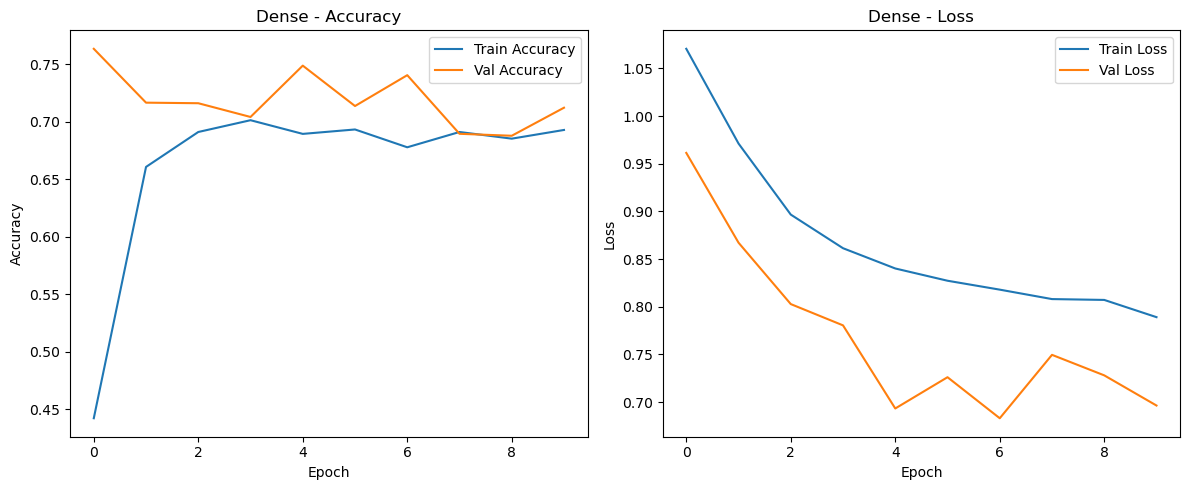

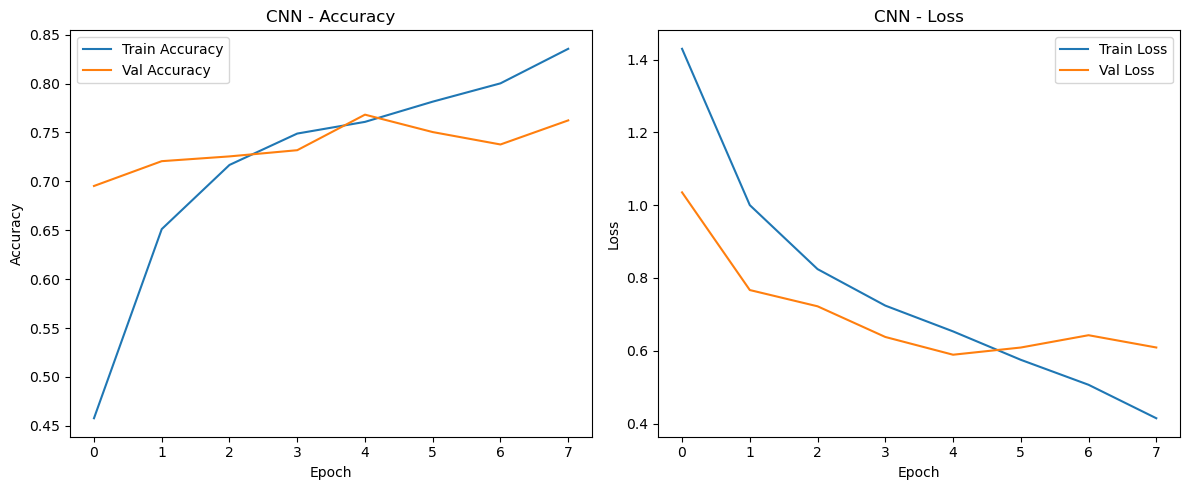

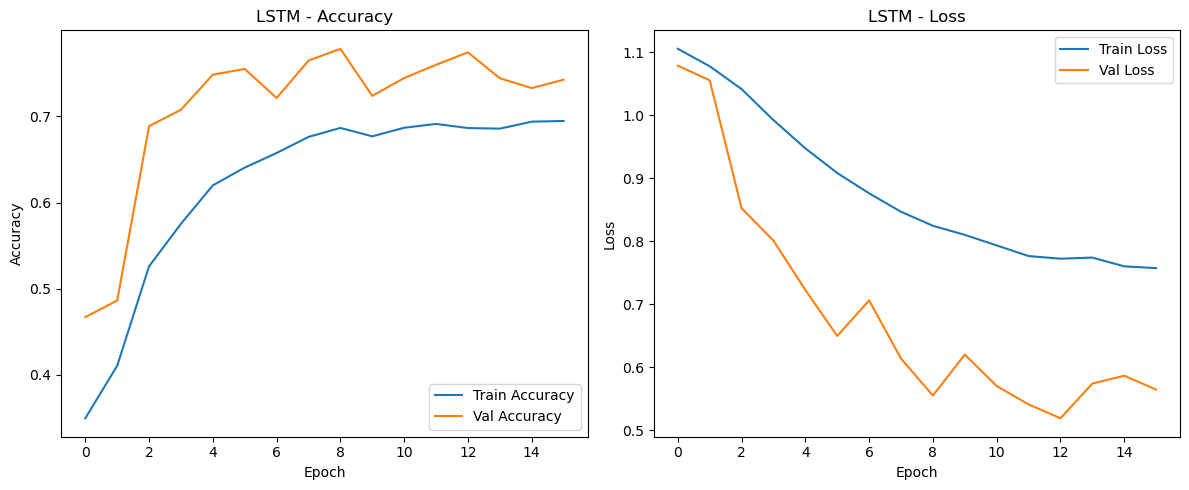

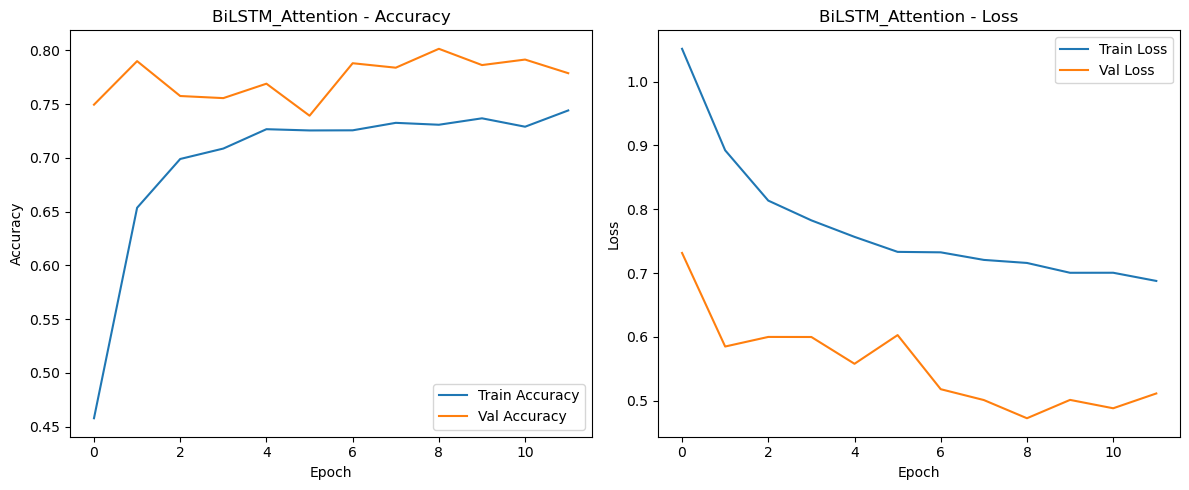

In [36]:
#Plot training history
def plot_history(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for each model
for name, res in results.items():
    plot_history(res['history'], title=name)

In [39]:
# Cell 19: Save all models
for name, result in results.items():
    result['model'].save(f'models/{name}_model.h5')

print("All models saved.")

All models saved.


In [37]:
#Prediction function
def predict_sentiment(review_text, model, tokenizer, max_len=150):
    cleaned = clean_text(review_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded, verbose=0)
    labels = ['Negative', 'Neutral', 'Positive']
    predicted_class = labels[pred.argmax()]
    confidence = pred.max()
    return predicted_class, confidence

# Test prediction
sample_review = "The hotel was amazing! Clean room and great staff."
label, conf = predict_sentiment(sample_review, results["CNN"]["model"], tokenizer)
print(f"Review: {sample_review}")
print(f"Predicted: {label} (Confidence: {conf:.2f})")

Review: The hotel was amazing! Clean room and great staff.
Predicted: Positive (Confidence: 0.97)


In [54]:
def predict_sentiment(review_text, model, tokenizer, max_len=150):
    cleaned = clean_text(review_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded, verbose=0)[0]
    labels = ['Negative', 'Neutral', 'Positive']
    pred_class = labels[pred.argmax()]
    confidence = pred.max()
    return pred_class, confidence

# Test
review = "The hotel was great, but the AC didn’t work."
# Run prediction on all models
for name, result in results.items():
    label, conf = predict_sentiment(review, result['model'], tokenizer)
    print(f"{name}: {label} (Confidence: {conf:.2f})")

Dense: Positive (Confidence: 0.88)
CNN: Positive (Confidence: 0.96)
LSTM: Positive (Confidence: 0.93)
BiLSTM_Attention: Positive (Confidence: 0.84)


In [ ]:
#Error analysis
import numpy as np

for model_name, result in results.items():
    y_true = result['y_true']
    y_pred = result['y_pred']
    wrong_idx = np.where(y_true != y_pred)[0]

    print(f"\n--- {model_name} - Misclassified Examples ---")
    for i in range(min(5, len(wrong_idx))):
        idx = wrong_idx[i]
        actual = ['Negative', 'Neutral', 'Positive'][y_true[idx]]
        pred = ['Negative', 'Neutral', 'Positive'][y_pred[idx]]
        print(f"📝 Actual: {actual} | Predicted: {pred}")
        print(f"💬 Review: {df['Review'].iloc[idx]}")
        print("-" * 60)


--- Dense - Misclassified Examples ---
📝 Actual: Neutral | Predicted: Negative
💬 Review: ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block 

# comparison between the models with and without cw

In [55]:
import pickle

with open('data/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

print("Tokenizer loaded.")

Tokenizer loaded.


In [60]:
from tensorflow.keras.models import load_model

# Define custom objects for models that use AttentionLayer
custom_objects = {'AttentionLayer': AttentionLayer}

# List of model names and file paths
model_paths = {
    "Dense": "models/Dense_model.h5",
    "CNN": "models/CNN_model.h5",
    "LSTM": "models/LSTM_model.h5",
    "BiLSTM_Attention": "models/BiLSTM_Attention_model.h5"
}

# Dictionary to store loaded models
loaded_models = {}

for name, path in model_paths.items():
    try:
        model = load_model(path, custom_objects=custom_objects if "BiLSTM" in name else {})
        loaded_models[name] = model
        print(f"{name} loaded successfully")
    except Exception as e:
        print(f"Error loading {name}: {e}")

Dense loaded successfully


CNN loaded successfully


LSTM loaded successfully


BiLSTM_Attention loaded successfully


In [62]:
review = "The hotel was great, but the AC didn’t work."

print(f"Input Review: '{review}'\n")
print("Predictions (Models trained with class weights):")

for name, model in loaded_models.items():
    label, conf = predict_sentiment(review, model, tokenizer)
    print(f"{name}: {label} (Confidence: {conf:.2f})")

Input Review: 'The hotel was great, but the AC didn’t work.'

Predictions (Models trained with class weights):
Dense: Neutral (Confidence: 0.39)
CNN: Positive (Confidence: 0.61)
LSTM: Positive (Confidence: 0.63)
BiLSTM_Attention: Positive (Confidence: 0.82)


In [63]:
print("\n--- Comparison ---")
print("Without CW | With CW     | Model")

for name in results.keys():
    label_now = predict_sentiment(review, results[name]['model'], tokenizer)[0]  # old model
    label_new = predict_sentiment(review, loaded_models[name], tokenizer)[0]     # new model
    print(f"{label_now:10} | {label_new:10} | {name}")


--- Comparison ---
Without CW | With CW     | Model
Positive   | Neutral    | Dense
Positive   | Positive   | CNN
Positive   | Positive   | LSTM
Positive   | Positive   | BiLSTM_Attention
